<a href="https://colab.research.google.com/github/asoushawk/octopusguesser/blob/master/prediction_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

In [ ]:
!pip install -q sklearn

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [ ]:
# Load dataset.
dftrain = pd.read_csv('http://testbella123.epizy.com/testtest.csv') # training data
dfeval = pd.read_csv('http://testbella123.epizy.com/train.csv') # testing data
y_train = dftrain.pop('winner')
print(dftrain.head())
y_eval = dfeval.pop('winner')
print(dftrain.head())


In [ ]:
CATEGORICAL_COLUMNS = [
"top_red_champion", 
"top_blue_champion",
"jg_red_champion",
"jg_blue_champion", 
"mid_red_champion", 
"mid_blue_champion",
"adc_red_champion", 
"adc_blue_champion",
"sup_red_champion", 
"sup_blue_champion"]
NUMERIC_COLUMNS = ["top_red_champion_ward", "top_red_rota_champion_month", "top_red_champion_alltime_wr", "top_red_champion_kda", 
"top_blue_champion_ward", "top_blue_rota_champion_month", "top_blue_champion_alltime_wr", "top_blue_champion_kda", 
"jg_red_champion_ward", "jg_red_rota_champion_month", "jg_red_champion_alltime_wr", "jg_red_champion_kda", 
"jg_blue_champion_ward", "jg_blue_rota_champion_month", "jg_blue_champion_alltime_wr", "jg_blue_champion_kda", 
"mid_red_champion_ward", "mid_red_rota_champion_month", "mid_red_champion_alltime_wr", "mid_red_champion_kda", 
"mid_blue_champion_ward", "mid_blue_rota_champion_month", "mid_blue_champion_alltime_wr", "mid_blue_champion_kda",
"adc_red_champion_ward", "adc_red_rota_champion_month", "adc_red_champion_alltime_wr", "adc_red_champion_kda",
"adc_blue_champion_ward", "adc_blue_rota_champion_month", "adc_blue_champion_alltime_wr", "adc_blue_champion_kda",
"sup_red_champion_ward", "sup_red_rota_champion_month", "sup_red_champion_alltime_wr", "sup_red_champion_kda",
"sup_blue_champion_ward", "sup_blue_rota_champion_month", "sup_blue_champion_alltime_wr", "sup_blue_champion_kda"]

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(list(feature_columns[49]))

['sup_blue_champion_kda', (1,), None, tf.float32, None]


In [ ]:
dftrain.head()

,top_red_champion,top_red_champion_ward,top_red_rota_champion_month,top_red_champion_alltime_wr,top_red_champion_kda,top_blue_champion,top_blue_champion_ward,top_blue_rota_champion_month,top_blue_champion_alltime_wr,top_blue_champion_kda,jg_red_champion,jg_red_champion_ward,jg_red_rota_champion_month,jg_red_champion_alltime_wr,jg_red_champion_kda,jg_blue_champion,jg_blue_champion_ward,jg_blue_rota_champion_month,jg_blue_champion_alltime_wr,jg_blue_champion_kda,mid_red_champion,mid_red_champion_ward,mid_red_rota_champion_month,mid_red_champion_alltime_wr,mid_red_champion_kda,mid_blue_champion,mid_blue_champion_ward,mid_blue_rota_champion_month,mid_blue_champion_alltime_wr,mid_blue_champion_kda,adc_red_champion,adc_red_champion_ward,adc_red_rota_champion_month,adc_red_champion_alltime_wr,adc_red_champion_kda,adc_blue_champion,adc_blue_champion_ward,adc_blue_rota_champion_month,adc_blue_champion_alltime_wr,adc_blue_champion_kda,sup_red_champion,sup_red_champion_ward,sup_red_rota_champion_month,sup_red_champion_alltime_wr,sup_red_champion_kda,sup_blue_champion,sup_blue_champion_ward,sup_blue_rota_champion_month,sup_blue_champion_alltime_wr,sup_blue_champion_kda
0,Renekton,17.3,100.0,47.4,5.400000,Volibear,8.9,62.5,49.7,5.325000,Graves,22.2,75.0,53.6,7.620000,Master Yi,19.8,66.7,57.1,8.800000,Akali,19.4,30.8,50.3,11.723077,Diana,19.8,52.4,52.8,11.723077,Jhin,19.1,35.0,52.5,3.000000,Senna,12.8,55.0,51.7,10.651282,Pantheon,0.5,71.4,54.3,10.469565,Taric,0.1,56.9,52.7,6.700000
1,Renekton,18.6,50.0,52.5,4.956604,Jax,8.9,51.0,49.7,8.200000,Diana,15.6,41.7,52.2,14.333333,Kayn,18.9,83.3,53.2,1.666667,Annie,19.4,52.4,50.3,6.488679,Lucian,11.3,42.9,55.2,6.488679,Senna,12.8,55.0,51.7,10.651282,Vayne,12.8,52.1,51.7,7.829412,Taric,0.1,56.9,52.7,6.700000,Leona,21.1,56.9,42.9,1.841270
2,Malphite,11.7,61.9,49.4,4.827273,Gangplank,8.9,54.5,49.7,3.880392,Lee Sin,19.6,100.0,52.1,14.333333,Graves,18.9,22.2,53.2,3.937500,Neeko,19.4,52.4,50.3,7.290909,Yasuo,18.9,31.3,51.1,7.290909,Senna,12.8,55.0,51.7,10.651282,Twitch,12.8,52.3,51.7,10.128571,Alistar,0.1,56.9,52.7,6.150000,Brand,0.3,38.5,47.9,1.841270
3,Fiora,19.5,25.0,54.8,7.428571,Darius,8.9,41.7,60.9,8.571429,Kayn,19.2,54.5,50.8,14.080822,Shyvana,19.2,28.6,54.8,8.800000,Yasuo,27.4,54.5,55.1,12.735616,Katarina,0.4,36.8,49.8,12.735616,Samira,12.8,55.0,51.7,8.000000,Kog'Maw,17.9,37.5,52.3,10.128571,Taric,0.1,56.9,52.7,6.700000,Leona,0.1,38.5,16.7,2.714286
4,Sett,16.3,48.0,54.3,10.166667,Darius,8.9,66.7,60.0,6.833333,Kayn,18.4,42.9,60.0,6.785714,Rek'Sai,28.2,51.6,49.1,8.800000,Yasuo,0.2,54.5,52.9,1.200000,Zed,19.8,61.8,52.8,1.200000,Kai'Sa,22.7,35.0,56.1,8.000000,Senna,12.8,55.0,51.7,10.651282,Leona,20.6,53.3,62.2,3.000000,Taric,0.1,56.9,52.7,6.700000


input function

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprz5unanu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.5


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprz5unanu/model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


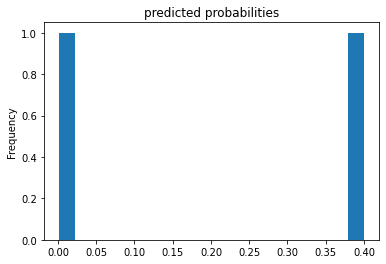

In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [ ]:
result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[1])
print(y_eval.loc[1])
print(result[1]['probabilities'][1])

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprz5unanu/model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
top_red_champion                   Teemo
top_red_champion_ward                 13
top_red_rota_champion_month            0
top_red_champion_alltime_wr         37.9
top_red_champion_kda             5.99767
top_blue_champion                  Poppy
top_blue_champion_ward               8.9
top_blue_rota_champion_month          75
top_blue_champion_alltime_wr        53.3
top_blue_champion_kda            7.15714
jg_red_champion                   Rengar
jg_red_champion_ward                11.3
jg_red_rota_champion_month          48.5
jg_red_champion_alltime_wr          32.3
jg_red_champion_kda              6.15385
jg_blue_champion                    Olaf
jg_blue_champion_ward               23.1
jg_blue_rota_champion_month         83.3
jg_blue_champion_alltime_wr   